In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset_train = pd.read_csv('Data/Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values # we need to take only the open column 

In [3]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

### In this step we choose if the model is sequence to sequence or sequence to model 

In [19]:
x_train = []
y_train = []
times_steps = 50

for j in range(0, len(training_set_scaled)-times_steps):
    x_train.append(training_set_scaled[j:j+times_steps, 0])
    y_train.append(training_set_scaled[j+times_steps, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)
print(x_train[0])
print(x_train[1]) # notice how there is some overlap between the two arrays, remember like we did in the MIT course, sequence_length, Hello -> Hell, ello, but there the sequence length was 4, here it is 60, but notice that there the sequence length for the input was equal to the output, but here it is not, the output is just the next value after the sequence length, so the output is not a sequence, but a single value. In this step we choose if the model is sequence to sequence or sequence to value.

(1208, 50)
(1208,)
[0.08581368 0.09701243 0.09433366 0.09156187 0.07984225 0.0643277
 0.0585423  0.06568569 0.06109085 0.06639259 0.0614257  0.07474514
 0.02797827 0.02379269 0.02409033 0.0159238  0.01078949 0.00967334
 0.01642607 0.02100231 0.02280676 0.02273235 0.02810849 0.03212665
 0.0433812  0.04475779 0.04790163 0.0440695  0.04648783 0.04745517
 0.04873875 0.03936305 0.04137213 0.04034898 0.04784582 0.04325099
 0.04356723 0.04286033 0.04602277 0.05398467 0.05738894 0.05714711
 0.05569611 0.04421832 0.04514845 0.04605997 0.04412531 0.03675869
 0.04486941 0.05065481]
[0.09701243 0.09433366 0.09156187 0.07984225 0.0643277  0.0585423
 0.06568569 0.06109085 0.06639259 0.0614257  0.07474514 0.02797827
 0.02379269 0.02409033 0.0159238  0.01078949 0.00967334 0.01642607
 0.02100231 0.02280676 0.02273235 0.02810849 0.03212665 0.0433812
 0.04475779 0.04790163 0.0440695  0.04648783 0.04745517 0.04873875
 0.03936305 0.04137213 0.04034898 0.04784582 0.04325099 0.04356723
 0.04286033 0.04602277

### Continuation of the last step

In [20]:
# dimension addition  for the x_train only 
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1)) # 1 is the number of indicators, in this case we have only one indicator, the open price of the stock, if we have more indicators we need to add them here. Like if we want to add the close price of the stock, we need to add it here, and the shape will be (x_train.shape[0],x_train.shape[1],2)
print(x_train.shape)

(1208, 50, 1)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [32]:
RNN = Sequential()
RNN.add(LSTM(units=50,return_sequences=True,input_shape = (x_train.shape[1],1),activation='tanh'))
RNN.add(Dropout(rate = 0.2))
RNN.add(LSTM(units=50,return_sequences=True,activation='tanh')) # the model will automatically know the input_shape from the previous layer 
RNN.add(Dropout(rate = 0.2))
RNN.add(LSTM(units=50,return_sequences=True,activation='tanh')) 
RNN.add(Dropout(rate = 0.2))
RNN.add(LSTM(units=50,return_sequences=False,activation='tanh')) 
RNN.add(Dropout(rate = 0.2))

# adding the output layer 
RNN.add(Dense(units = 1))

In [33]:
RNN.compile(optimizer='adam',loss = 'mean_squared_error')

In [34]:
RNN.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
38/38 [==============================] - 11s 58ms/step - loss: 0.0447
Epoch 2/100
38/38 [==============================] - 2s 59ms/step - loss: 0.0057
Epoch 3/100
38/38 [==============================] - 2s 62ms/step - loss: 0.0052
Epoch 4/100
38/38 [==============================] - 2s 64ms/step - loss: 0.0052
Epoch 5/100
38/38 [==============================] - 2s 63ms/step - loss: 0.0048
Epoch 6/100
38/38 [==============================] - 2s 62ms/step - loss: 0.0050
Epoch 7/100
38/38 [==============================] - 2s 65ms/step - loss: 0.0040
Epoch 8/100
38/38 [==============================] - 2s 60ms/step - loss: 0.0046
Epoch 9/100
38/38 [==============================] - 2s 61ms/step - loss: 0.0041
Epoch 10/100
38/38 [==============================] - 3s 68ms/step - loss: 0.0043
Epoch 11/100
38/38 [==============================] - 2s 62ms/step - loss: 0.0038
Epoch 12/100
38/38 [==============================] - 2s 63ms/step - loss: 0.0038
Epoch 13/100
38/38 [====

In [35]:
test_set = pd.read_csv('Data/Google_Stock_Price_Test.csv')
real_stock_price = test_set.iloc[:, 1:2].values

In [36]:
# predicted price 
dataset_total = pd.concat((dataset_train['Open'], test_set['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_set) - times_steps:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(0,len(inputs)-times_steps):
    X_test.append(inputs[i:i+times_steps, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = RNN.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 [==============================] - 3s 3s/step


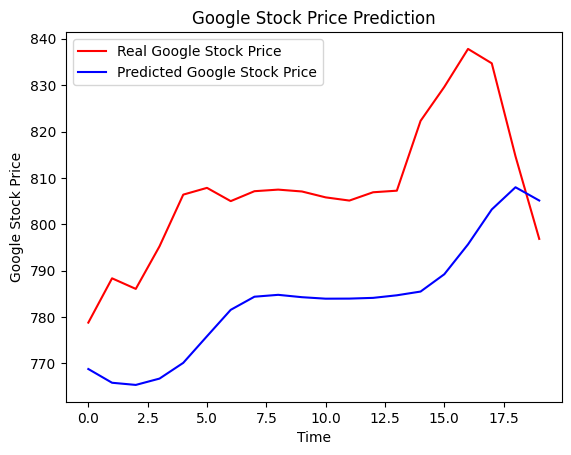

In [37]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()